In [24]:
import csv
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import mediapipe as mp
from sklearn.metrics import confusion_matrix
import numpy as np


In [2]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose

# Directory for TensorFlow.js model
tfjs_model_dir = 'model'


In [3]:
# Load CSV file
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(df.columns[0], axis=1, inplace=True)  # Drop filename column
    class_names = df['class_name'].unique().tolist()
    df['class_no'] = df['class_name'].apply(lambda x: class_names.index(x))
    y = keras.utils.to_categorical(df.pop('class_no'))
    X = df.iloc[:, :-1].astype('float64')  # Exclude class_name column
    return X, y, class_names

In [4]:
# Normalize pose landmarks
def normalize_pose_landmarks(landmarks):
    landmarks = tf.convert_to_tensor(landmarks, dtype=tf.float32)
    pose_center = (landmarks[mp_pose.PoseLandmark.LEFT_HIP.value][:2] +
                   landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value][:2]) / 2
    landmarks = landmarks[:, :2] - pose_center  # Normalize to hip center
    pose_size = tf.reduce_max(tf.norm(landmarks, axis=1))
    landmarks /= pose_size  # Scale landmarks
    return landmarks

In [5]:
# Convert landmarks to embeddings
def landmarks_to_embedding(landmarks):
    normalized_landmarks = normalize_pose_landmarks(landmarks)
    embedding = tf.reshape(normalized_landmarks, [-1])  # Flatten to 66 values
    return embedding

In [6]:
# Preprocess dataset
def preprocess_data(X_data):
    processed_X = []
    for i in range(X_data.shape[0]):
        embedding = landmarks_to_embedding(X_data.iloc[i].values.reshape(33, 3))  # Ensure 33 landmarks
        processed_X.append(embedding)
    return tf.convert_to_tensor(processed_X)


In [7]:
import tensorflow.keras as keras

print(tf.__version__)
print(tf.keras.__version__)



2.18.0
3.8.0.dev2025021303


In [8]:
# Load and process data
X, y, class_names = load_csv('train_data.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
X_test, y_test, _ = load_csv('test_data.csv')

processed_X_train = preprocess_data(X_train)
processed_X_val = preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

In [9]:
# Build Model
inputs = tf.keras.Input(shape=(66,))  # 33 landmarks * 2 (x, y normalized)
layer = keras.layers.Dense(256, activation='relu')(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(128, activation='relu')(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation='softmax')(layer)

model = keras.Model(inputs, outputs)


In [10]:
# Compile Model
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint_path = "weights.best.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=30)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.5,
                                              patience=5,
                                              min_lr=1e-6)

In [11]:
# Train Model
print('--------------TRAINING----------------')
history = model.fit(processed_X_train, y_train,
                    epochs=250,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


--------------TRAINING----------------
Epoch 1/250
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1926 - loss: 2.0378
Epoch 1: val_accuracy improved from -inf to 0.32914, saving model to weights.best.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1928 - loss: 2.0373 - val_accuracy: 0.3291 - val_loss: 1.7904
Epoch 2/250
194/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3535 - loss: 1.7431
Epoch 2: val_accuracy improved from 0.32914 to 0.50540, saving model to weights.best.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3539 - loss: 1.7422 - val_accuracy: 0.5054 - val_loss: 1.5228
Epoch 3/250
177/197 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4509 - loss: 1.5519
Epoch 3: val_accuracy improved from 0.50540 to 0.58094, saving model to weights.best.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4518 - loss: 1.5498 - val_accuracy: 0.5809 - val_loss: 1.3380
Epoch 4/250
190/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4850 - loss:

In [21]:
# Get true labels (convert one-hot encoding to class indices)
y_true_classes = np.argmax(y_test, axis=1)

# Get predicted labels
y_pred = model.predict(processed_X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


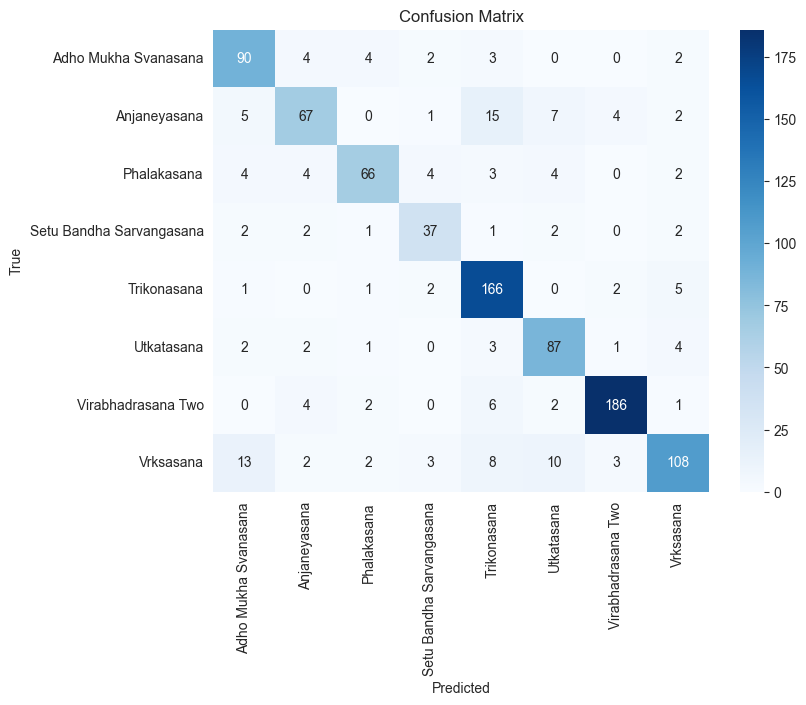

In [26]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from sklearn.metrics import classification_report

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

                          precision    recall  f1-score   support

    Adho Mukha Svanasana       0.77      0.86      0.81       105
            Anjaneyasana       0.79      0.66      0.72       101
             Phalakasana       0.86      0.76      0.80        87
Setu Bandha Sarvangasana       0.76      0.79      0.77        47
             Trikonasana       0.81      0.94      0.87       177
              Utkatasana       0.78      0.87      0.82       100
      Virabhadrasana Two       0.95      0.93      0.94       201
               Vrksasana       0.86      0.72      0.79       149

                accuracy                           0.83       967
               macro avg       0.82      0.82      0.81       967
            weighted avg       0.84      0.83      0.83       967



In [12]:
# Evaluate Model
print('-----------------EVALUATION----------------')
loss, accuracy = model.evaluate(processed_X_test, y_test)
print('LOSS:', loss)
print('ACCURACY:', accuracy)

# Save Model for TensorFlow.js
#tfjs.converters.save_keras_model(model, tfjs_model_dir)
#print('tfjs model saved at', tfjs_model_dir)


-----------------EVALUATION----------------
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8222 - loss: 0.7015
LOSS: 0.5921224355697632
ACCURACY: 0.8345398306846619


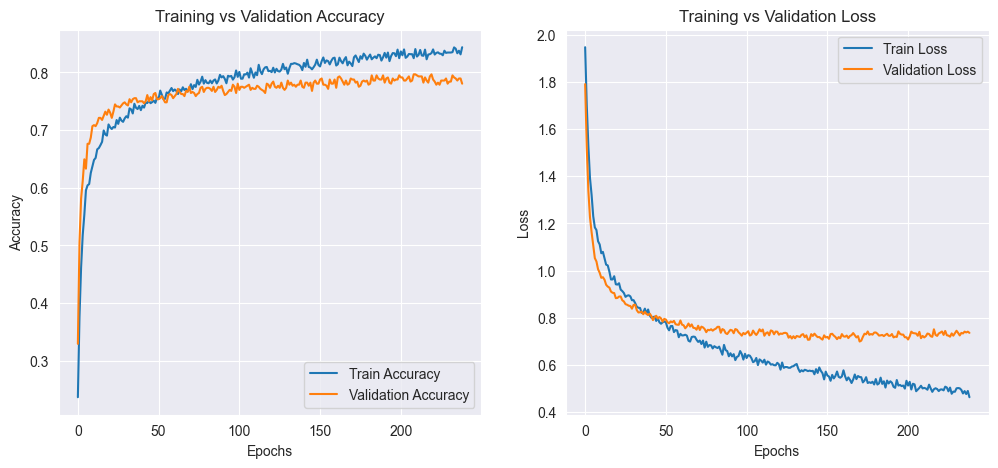

In [29]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()
